# Santander Customer Satisfaction

## Initialization

### Dependencies

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

### Visualization Settings

In [4]:
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# sns.palplot(sns.color_palette())

### Files

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# data = train.drop('TARGET', axis=1).append(test)

## Data Exploring

In [6]:
train.shape

(76020, 371)

In [7]:
test.shape

(75818, 370)

In [8]:
set(train.columns) - set(test.columns)

{'TARGET'}

### Overview

In [9]:
n_customers = len(train)
n_unsatisfied = train.TARGET.sum()
n_satisfied = (train.TARGET==0).sum()
satisfaction_rate = float(n_satisfied)/n_customers

features = test.columns.drop('ID').tolist()
n_features = len(features)

print("Total number of customers: {}".format(n_customers))
print("Number of satisfied customers: {}".format(n_satisfied))
print("Number of unsatisfied customers: {}".format(n_unsatisfied))
print("Satisfaction rate: {:.2f}%".format(satisfaction_rate*100))
print("Number of features: {}".format(n_features))

Total number of customers: 76020
Number of satisfied customers: 73012
Number of unsatisfied customers: 3008
Satisfaction rate: 96.04%
Number of features: 369


### ID Analysis

In [10]:
len(set(train.ID)) == len(train)

True

In [11]:
train_id = train.ID
test_id = test.ID
train.drop('ID', inplace=True, axis=1)
test.drop('ID', inplace=True, axis=1)

### Target Analysis

### Exploring Features

## Data Preparation
- Missing values. `train.columns[train.isnull().any()].tolist()`
- Outliers and strange values
- Remove duplicated features
- Remove useless features
- Remove useless and duplicated features checking it not only on training set but also on testing set (but maybe they could be useful on validation set).
- This dataset has some repeated instances but with both class label, so that instances are noise. What I made was extract that noisy instances from the complete dataset. After that, I splitted the resulting complete dataset in 5 partitions and I ran xgboost on each one. Then, I made a majority vote of the five resulting predictions for each noisy instance that I extrated at the begining. Finally, I inserted that instances with the real class label.

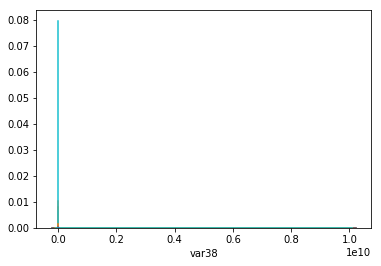

In [42]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

### Cleaning

In [12]:
def replace_weird(dfs, weird = [-999999, 9999999999.00]):
    for df in dfs:
        modes = df.mode()
        for col in df.columns:
            if any([i in df[col].values for i in weird]):
#                 df['weird_'+col] = df[col].isin(weird)
                df[col].mask(df[col].isin(weird), modes[col][0], inplace=True)

replace_weird([train, test])

In [13]:
def remove_useless(dfs):
    remove = []
    for df in dfs:
        for col in df.columns:
            if df[col].std() == 0:
                remove.append(col)
    for df in dfs:
        df.drop(set(remove), axis=1, inplace=True)

remove_useless([train, test])

In [14]:
def duplicated(df):
    duplicated = []
    c = df.columns
    for i in range(len(c)-1):
        v = df[c[i]].values
        for j in range(i+1,len(c)):
            if np.array_equal(v,df[c[j]].values):
                duplicated.append(c[j])
    return set(duplicated)


duplicated_train = duplicated(train)
duplicated_test = duplicated(test)

if duplicated_test.issubset(duplicated_train):
    print('Duplicated columns on test set are also duplicated on training set.\
          \nAll duplicated being removed from both sets')
    train.drop(duplicated_train, axis=1, inplace=True)
    test.drop(duplicated_train, axis=1, inplace=True)

Duplicated columns on test set are also duplicated on training set.          
All duplicated being removed from both sets


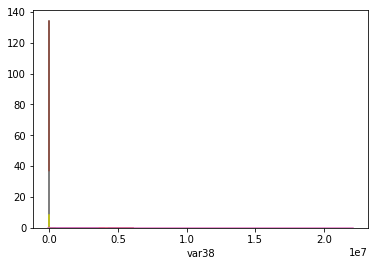

In [46]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

### Preprocessing

### Scaling
- https://discuss.analyticsvidhya.com/t/methods-to-deal-with-zero-values-while-performing-log-transformation-of-variable/2431/3
- Robust Scaler
- Log Scaler
- Scale Test

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
# log scaler

floats = train.select_dtypes('float').columns
train[floats] = pd.DataFrame(standard_scaler.fit_transform(train[floats]), columns=floats)

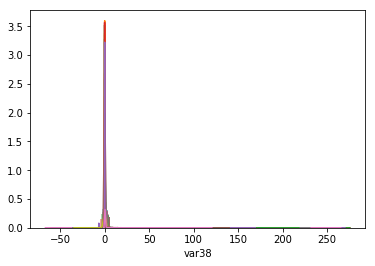

In [66]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

## Models

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True) # Convert a metric to a scorer.

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [17]:
X = np.array(train.drop('TARGET', axis=1))
y = np.array(train['TARGET'])

### Benchmark

In [18]:
'All zeros benchmark has ROC_AUC score of {}'.format(roc_auc_score(train.TARGET, np.zeros_like(train.TARGET)))

'All zeros benchmark has ROC_AUC score of 0.5'

### Baseline
- Base Models
- Grid Search
- Model descriptions, strengths and weakness

#### NaiveBayes

In [19]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
cross_val_score(nb_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.5374590966343075

#### LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(class_weight={0:0.2, 1:0.8})
cross_val_score(lr_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.7931621123193534

#### DecisionTree

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
cross_val_score(dt_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.5715716850857125

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(min)
cross_val_score(dt_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.5715716850857125

#### SVC

In [22]:
# from sklearn.svm import SVC

# sv_classifier = SVC()
# cross_val_score(sv_classifier, X, y, cv=3, scoring=roc_auc_scorer).mean()

#### MLP Classifier
- http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [23]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier()
cross_val_score(mlp_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.7980524557572463

In [29]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(200,50))
cross_val_score(mlp_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.7761793922411119

#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=3)
cross_val_score(rf_classifier, X, y, cv=5, scoring='roc_auc').mean()

0.6753461077617808

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_features=50, random_state=3)
cross_val_score(rf_classifier, X, y, cv=5, scoring='roc_auc').mean()

0.7610352546192394

#### XGBoost

In [26]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
cross_val_score(xgb_classifier, X, y, cv=3, scoring='roc_auc').mean()

0.8365909544900069

## Feature Engineering
- OneHotEncode'em all
- Binary feature for each feature on the dataset. `1 if feature == feature.mode() else 0`
- Add column that sum zeros on row. `train['zeros'] = (train==0).sum(axis=1).astype(float)`
- Add column that sums values in row. 
- PCA and other dimensionality reduction on low importance features.
- ONE-HOT encode features with more than 2 and less than 'limit' unique values
- Test importance of new features

### Feature correlation and importance

In [ ]:
def get_importance(features, model):

### One Hot Encoding

In [64]:
one_hot = {c: list(train[c].unique()) for c in train[features].select_dtypes('int').columns}

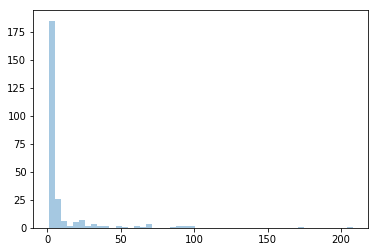

In [65]:
sns.distplot([len(i) for i in one_hot.values()], kde=False);

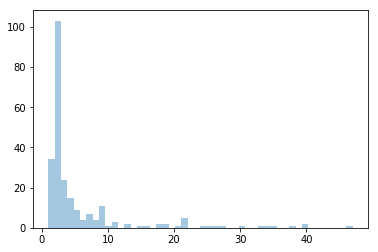

In [66]:
sns.distplot([len(i) for i in one_hot.values() if len(i)<50], kde=False);

In [67]:
def OHE_by_unique(df, one_hot, limit):    
    #ONE-HOT encode features with more than 2 and less than 'limit' unique values
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)

OHE_by_unique(train, one_hot, 10)

#### Scale remainders of OHE (unique < limit)
transform unique?limit to float at begining

### Value == Mode

In [279]:
def check_if_is_mode(df):
    modes = df.mode()
    for c in df.columns:
        df['is_mode_of_'+c] = df[c]==modes[c]

check_if_is_mode(train)
check_if_is_mode(test)

### Count zeros

In [32]:
def count_zeros(df):
    df['zeros'] = (df==0).sum(axis=1).astype(float)
    
count_zeros(train)
count_zeros(test)

### Extra Features

### Feature correlation and importance

## Parameter Optmization
#### Grid Search

### Cross Validation Test
- comparar:
    - CrossValidation inside and outside (parameter to toggle between True and False)
    - faz diferença?

In [206]:
def cross_val_model(X,y, model, n_splits=5, scoring='roc_auc', undersampling_folds=True):
    if outside_cv:
        X = np.array(X)
        y = np.array(y)

        folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1).split(X, y))
        score = 0

        for j, (train_idx, test_idx) in enumerate(folds):
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_holdout = X[test_idx]
            y_holdout = y[test_idx]

            print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
            model.fit(X_train, y_train)
            cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring=scoring)
            score+= cross_score.mean()
        score = score/n_splits
    else:
        score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring=scoring).mean()
        
        # check if sklearn cross_val uses stratified kfold
        
    print("    cross_score: %.5f" % score)

### Undersampling
- This dataset is highly unbalanced, so using the new dataset without noise, I made an undersampling as follows: first, I splitted the dataset in the instances which have class label 0 and the instances which have class label 1. Later, I splitted the instances with 0 class into (number_of_class0/number_of_class1) partitions (24 partitions) and I joined each partition with the partition of instances of 1 class label made before. Finally, I ran xgboost on each new balanced partition and I made an average with the predictions of the 24 models.
- Add this undersampling method to cross val function, with partameter to toggle on/off.

## Stacking / Voting

## Ideas
- Add noise to target
- Add noise to target after folding, and train a regressor.
- Replicate datapoints with TARGET=1. 
- Replicate datapoints with TARGET=1. Add noise.
- Unbalanced features: check if they give info about target. Try to combine them. Remove excess.
- Remaining features: check if they give info using FacetGrid. Apply transformations and check again. Trying to kernel trick.
- Simplyfy cross-validation using only sklearn's cross_val_score.
- Remove datapoints that have outliers if target=0
- Submit using Kaggle api. import kaggle
- plotar distribuicao dos scores finais da competicao
- mostrar minha posicao comparada as outras notas sem rankear. estara mto mais proxima do primeiro lugar do que do benchmark
- ao terminar o projeto, responder email antigo da cristina junqueira
- Review previous projects' and live's notebooks ot see if there's something to be added
- Test the baseline with unprocessed data
- Test the baseline with unscaled data
- GridSearch again at the end, after feature engineering
- SVM on low importance features.
- drop duplicated columns. `train.T.drop_duplicates().T`
- fit scaler to whole data (train + test)

## Sklearn Pipeline (Optional)
### Scalers
### Cross Validation Folds
### Models
### Grid Search

- https://stackoverflow.com/questions/49262900/scaling-data-using-pipelines-in-scikit-learn-standardscaler-vs-robustscaler

---

### Visualization Options

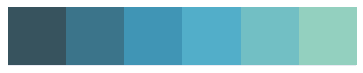

In [2]:
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.display import set_matplotlib_formats
pd.options.display.float_format = '{:.2f}'.format
# sns.set(color_codes=True, palette=sns.palplot(sns.cubehelix_palette(8)))
# sns.set_palette("cubehelix_palette")
%matplotlib inline
# set_matplotlib_formats('pdf', 'png')
rc={'savefig.dpi': 75,    'figure.autolayout': False,    'figure.figsize': [8, 6],    'axes.labelsize': 18,    'axes.titlesize': 18,    'font.size': 18,    'lines.linewidth': 2.0,    'lines.markersize': 8,    'legend.fontsize': 16,    'xtick.labelsize': 16,    'ytick.labelsize': 16,    }
# sns.set(style='dark')
sns.set(style='dark',rc=rc)
# default_color = '#56B4E9'
colormap = plt.cm.cool
# Import supplementary visualizations code visuals.py
# import visuals as vs
# Setting working directory
# path = '../data/raw/'
sns.set_palette(sns.cubehelix_palette(50))
sns.set_palette('GnBu_d')
sns.palplot(sns.color_palette())

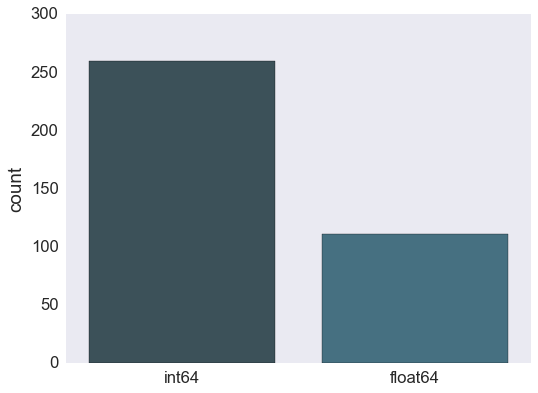

In [5]:
# sns.countplot(meta.d_type);
sns.countplot(train.dtypes);

In [ ]:
plt.xticks(rotation=90)
plt.title('Some variables have several features related o it:')
sns.countplot(meta.variable);

In [ ]:
plt.title('Some features may appear for lots of variables. Others are variable specific.')
meta.attribute.value_counts().head(15).plot(kind='bar');

In [ ]:
plt.title('Most integer features have less than 25 unique values.')
plt.xticks(size=8, rotation=30)
sns.countplot(meta.loc[(meta.d_type=='integer') & meta.keep].n_unique);

In [ ]:
plt.xticks(size=8, rotation=90)
sns.countplot(meta.loc[(meta.d_type=='float') & meta.keep].n_unique);

In [ ]:
# for c in train[meta.loc[(meta.d_type=='float') & meta.keep]['name']]:
#     sns.kdeplot(train[c].apply(lambda x: 0.0001 if x==0 else x).apply(np.log), legend=False)
#     sns.kdeplot(train[c].apply(np.log), legend=False)

In [ ]:
for c in train.select_dtypes('float'):
    sns.distplot(train[c]);

In [ ]:
sns.countplot(meta.d_type);

## Data Preparation / Preprocessing / Scaling 

In [ ]:
remove data which meta[keep=false]

In [ ]:
train[col].max().sort_values()

In [ ]:
train['delta_num_compra_var44_1y3'].value_counts()

In [ ]:
for c in col2:
    sns.distplot(train[c].apply(lambda x: np.log(x+1.23456789)))

In [ ]:
# adiantando 
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

def OHE_by_unique(df, one_hot, limit):
    
    #ONE-HOT encode features with more than 2 and less than 'limit' unique values
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
OHE_by_unique(train, one_hot, 10)

In [ ]:
# Remove constant features

def identify_constant_features(dataframe):
    count_uniques = dataframe.apply(lambda x: len(x.unique()))
    constants = count_uniques[count_uniques == 1].index.tolist()
    return constants

constant_features_train = set(identify_constant_features(train_dataset))

print('There were {} constant features in TRAIN dataset.'.format(
        len(constant_features_train)))

# Drop the constant features
train_dataset.drop(constant_features_train, inplace=True, axis=1)


## Benchmark

In [ ]:
'All zeros benchmark has ROC_AUC score of {}'.format(roc_auc_score(train.TARGET, np.zeros_like(train.TARGET)))

## Baseline

In [213]:
def cross_val_model(X,y, model, n_splits=5):
    X = np.array(X)
    y = np.array(y)

    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1).split(X, y))
    score = 0
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print(cross_score.mean())
        score+= cross_score.mean()
    score = score/n_splits
    print("    cross_score: %.5f" % score)

In [214]:
# Initialize models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier()
# clf_C = SVM()
clf_D = LogisticRegression()
clf_E = RandomForestClassifier()

X = train.drop('TARGET', axis=1)
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']

# u'strange_in_TARGET' should be droped

# # TODO: Execute the 'train_predict' function for each classifier and each training set size
# for clf in [clf_A, clf_B, clf_C]:
#     for X_set, y_set in [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]:
#         train_predict(clf, X_set, y_set, X_test, y_test)
#         print

In [215]:
cross_val_model(X, y, clf_A)
cross_val_model(X, y, clf_B)
# cross_val_model(X, y, clf_C)
cross_val_model(X, y, clf_D)
cross_val_model(X, y, clf_E)

Fit GaussianNB fold 1
0.5383638500144288
Fit GaussianNB fold 2
0.5232403335529742
Fit GaussianNB fold 3
0.5361399576207746
Fit GaussianNB fold 4
0.5356069617075271
Fit GaussianNB fold 5
0.5317914890445244
    cross_score: 0.53303
Fit DecisionTreeClassifier fold 1
0.5581280479549477
Fit DecisionTreeClassifier fold 2
0.5659181928915068
Fit DecisionTreeClassifier fold 3
0.5559330271160843
Fit DecisionTreeClassifier fold 4
0.5561279287486526
Fit DecisionTreeClassifier fold 5
0.5616064872781559
    cross_score: 0.55954
Fit LogisticRegression fold 1
0.37906670294236494
Fit LogisticRegression fold 2
0.38076612457038816
Fit LogisticRegression fold 3
0.3823086880003432
Fit LogisticRegression fold 4
0.38821932243603624
Fit LogisticRegression fold 5
0.37126160279732473
    cross_score: 0.38032
Fit RandomForestClassifier fold 1
0.6683274533777285
Fit RandomForestClassifier fold 2
0.6574936381540525
Fit RandomForestClassifier fold 3
0.6602220610255635
Fit RandomForestClassifier fold 4
0.67041474762

In [ ]:
cross_val_model(X, y, clf_E)

In [ ]:
pd.DataFrame(clf_E.feature_importances_, index=X.columns).sort_values(0, ascending=False)

In [ ]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'C': [0.01, 0.1, 1, 10, 100],
             'degree': [1,2,3,4,5],
             'kernel':  ['linear', 'poly', 'rbf', 'sigmoid']}

# TODO: Initialize the classifier
clf = SVM()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [11]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.2
xgb_params['n_estimators'] = 10
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [9]:
X = train.drop(['TARGET', 'ID', 'strange_in_TARGET'], axis=1)
y = train['TARGET']
X_test = test.drop(['ID'], axis=1)

In [12]:
XGB_model = XGBClassifier(**xgb_params)

In [13]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Fit XGBClassifier fold 4
Fit XGBClassifier fold 5
    cross_score: 0.81420


In [15]:
XGB_model.fit(X,y, eval_metric=roc_auc_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [18]:
ypred = XGB_model.predict_proba(test.drop('ID', axis=1))

In [24]:
sub = pd.DataFrame()
sub['id'] = test['ID'].values
sub['target'] = ypred[:,1]
sub.to_csv('baselineXGB.csv', index=False)

In [33]:
NN_Classifier = MLPClassifier(hidden_layer_sizes=(500, 500, 250, 100, 50))

In [34]:
NN_Classifier.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500, 500, 250, 100, 50),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
ypred2 = NN_Classifier.predict_proba(test.drop('ID', axis=1))

In [36]:
sub2 = pd.DataFrame()
sub2['id'] = test['ID'].values
sub2['target'] = ypred2[:,1]
sub2.to_csv('baselineNN.csv', index=False)

#### Support Vector Classifier with kernel trick

#### Random Forest Model

In [ ]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

clf_F = RandomForestClassifier(**rf_params)

In [ ]:
X = train.replace([np.inf, -np.inf], np.nan).dropna().drop('TARGET', axis=1)
y = train.dropna()['TARGET']

In [ ]:
cross_val_model(X, y, clf_F) # unscaled

#### Test the baseline with unprocessed data 

In [ ]:
v = 'var5'
sns.pairplot(train[meta.loc[(meta.d_type=='float') & (meta.variable==v) & meta.keep].name]);

In [ ]:
meta

In [ ]:
sns.FacetGrid(train, hue="TARGET", size=6).map(sns.kdeplot, "var15").add_legend()
plt.title('Unhappy customers are slightly older');

### Feature correlation and importance

In [ ]:
v = 'var1'
display(meta.loc[meta.variable==v].set_index('name'))
sns.pairplot(train[meta.loc[meta.variable==v]['name']]);

In [ ]:
"Regressor to check features importance (as done in customer_segments project)."
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
variable = 'ind_var8_0'
new_data = data.drop(feature, axis=1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], test_size = 0.25, random_state=3)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=3)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
score

In [ ]:
train[feature_names].corr()

ver se da pra estimar features a partir de outras. parece q tem feature q eh bucket de outra
ver se da pra estimar integers e binary a partir dos floats

def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df


feature_importance = get_feature_importance_df(rf.feature_importances_, features)
feature_importance

# fig,ax = plt.subplots()
# fig.set_size_inches(20,10)
# sns.barplot(data=feature_importance[:10],x="feature",y="importance",ax=ax,color=default_color,)
# ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances");

# sns.barplot(data=feature_importance[:10],x="feature",y="importance");


# Testing feature importantes with Random Forest

train.fillna(-1, inplace=True)

rf = RandomForestClassifier(n_estimators=150,
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2,
                            n_jobs=-1,
                            random_state=42)


rf.fit(train.drop(['target'],axis=1), train.target)
features = train.drop(['target'],axis=1).columns.values
print("----- Training Done -----")


# Continuous features analysis

col_internval

corr_m = train[col_internval].corr()
corr_m

plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True);








"Regressor to check features importance (as done in customer_segments project)."
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
feature = 'Delicatessen'
new_data = data.drop(feature, axis=1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], test_size = 0.25, random_state=3)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=3)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
score

In [ ]:
sns.pairplot(train[variables['var7']]);
sns.pairplot(train[variables['var8']]);

In [ ]:
v = 'saldo_medio_var13_largo_ult3'
sns.kdeplot(train[v].apply(np.log));

In [ ]:
sns.kdeplot(train.var38.apply(lambda x: np.log(x+1)));

In [ ]:
sns.distplot(train['var38']);

In [ ]:
sns.distplot(train['var38'].apply(np.log));

In [ ]:
sns.countplot(train.dtypes);

In [ ]:
sns.countplot('TARGET',data=train);

**GridsearchCV** (http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV)

sklearn.grid_search.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise’)[source]

cv : int, cross-validation generator or an iterable, optional

Determines the cross-validation splitting strategy. Possible inputs for cv are:

None, to use the default 3-fold cross-validation,
integer, to specify the number of folds.
An object to be used as a cross-validation generator.
An iterable yielding train/test splits.
For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, sklearn.model_selection.StratifiedKFold is used. In all other cases, sklearn.model_selection.KFold is used.

"oneHotEncode'em all"

In [ ]:
# evolution features (relationships within variable attrivbutes): imp_op_var39_comer_ult1 > imp_op_var39_comer_ult3

import itertools
for variable in set(meta.variable):
    v_combs = [list(i) for i in itertools.combinations(meta[meta.variable==variable]['name'], 2)]
    for comb in v_combs:
        train[comb[0]+'GT'+comb[1]] = train[comb[0]] > train[comb[1]]

In [ ]:
train.shapex

In [ ]:
# Initialize models
clf_A = NaiveBayes()
clf_B = DecisionTree()
clf_C = SVM()
clf_D = LogisticRegression()
clf_E = RandomForestClassifier()

X = train.drop('TARGET', axis=1)
X = train.drop(['TARGET', 'ID'], axis=1)
y = train['TARGET']

In [ ]:
cross_val_model(X, y, clf_A)
cross_val_model(X, y, clf_B)
# cross_val_model(X, y, clf_C)
cross_val_model(X, y, clf_D)
cross_val_model(X, y, clf_E)

In [37]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

# scaling features
# TODO: Scale the data using the natural logarithm
log_data = data.apply(np.log)

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.apply(np.log)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

NameError: name 'X_all' is not defined

In [123]:
from sklearn.preprocessing import OneHotEncoder

---

# Rascunho

In [205]:
from sklearn.model_selection import StratifiedKFold



In [6]:
### Dependencies

import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import random
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
import kaggle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB as NaiveBayes
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
# import itertools
# import missingno as msno
# import gc
# from sklearn.metrics import f1_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB as NaiveBayes
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVC as SVM
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture as GM
# from hyperopt.pyll.base import scope
# from hyperopt.pyll.stochastic import sample
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

SystemExit: Unauthorized: you must download an API key from https://www.kaggle.com/<username>/account
Then put kaggle.json in the folder /Users/vieiraad/.kaggle

In [ ]:
def get_meta(df):
    data = []
    for col in df.columns:
        # Defining the role
        if col == 'TARGET':
            role = 'target'
        elif col == 'ID':
            role = 'id'
        else:
            role = 'input'
            
        # Defining variable which is related to and attributes of this variable
        variable = ''.join(filter(lambda x: any(v in x for v in ['var', 'ID', 'TARGET']), col.split('_')))
        attribute = col.replace(variable, '').replace('__', '_')
        if attribute in ['', variable]: attribute = 'root'
        variable = variable.replace('cte', '')

        # Defining nunique 
        nunique = df[col].nunique()

#         # Initialize keep to True for all variables except for id or useless variables (nunque < 2)
#         keep = True
#         if role == 'id' or nunique<2:
#             keep = False
        # Measuring Mode Strength -- ver isso para os features integers

        # Defining the data type 
        if nunique == 2:
            dtype = 'binary'
        elif df[col].dtype == type(2):
            dtype = 'integer'
        elif df[col].dtype == type(0.1):
            dtype = 'float'

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'name'     : col,
            'role'     : role,
            'variable' : variable,
            'attribute': attribute,
            'n_unique'  : nunique,
            'd_type'     : dtype,
#             'keep'     : keep
        }
        
        data.append(col_dict)
#     meta = pd.DataFrame(data, columns=['name', 'role', 'variable', 'attribute','n_unique', 'd_type', 'keep'])
    meta = pd.DataFrame(data, columns=['name', 'role', 'variable', 'attribute','n_unique', 'd_type'])
    return meta

meta = get_meta(train)

In [14]:
import requests
username = ''
password = ''
competition_id='3136' #the code for titanic

session = requests.Session()
get_me = 'https://www.kaggle.com/account/login?ReturnUrl=%2fc%2f' + competition_id + '%2fpublicleaderboarddata.zip'
response = session.get(get_me) #call it once to get the request verification cookie
payload = {'username': username,' password':password, '__RequestVerificationToken': session.cookies.get('__RequestVerificationToken')}
r = session.post(get_me, data=payload)
with open('the-zip.zip', 'wb') as f:
    f.write(r.content)

'https://www.kaggle.com/account/login?ReturnUrl=%2fc%2fsantander-customer-satisfaction%2fpublicleaderboarddata.zip'
'https://www.kaggle.com/account/login?ReturnUrl=%2fc%2fsantander-customer-satisfaction%2fprivateleaderboarddata.zip'

KeyboardInterrupt: 

In [19]:
scores = pd.read_csv('../../Downloads/santander-customer-satisfaction-publicleaderboard.csv')

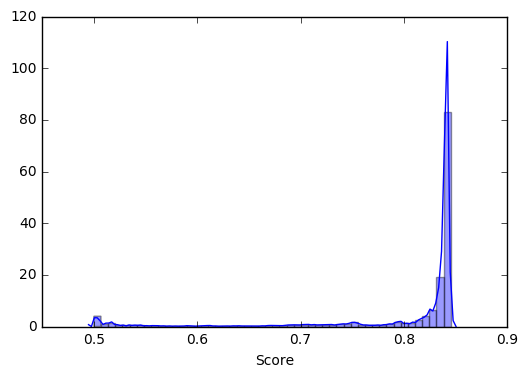

In [31]:
sns.distplot(scores.loc[scores.Score>0.5].Score);

In [33]:
scores

,TeamId,TeamName,SubmissionDate,Score
0,285018,Alexander Makeev,2016-03-02 20:33:18,0.823
1,286451,#1 Leustagos,2016-03-02 20:37:47,0.838
2,285018,Alexander Makeev,2016-03-02 20:59:34,0.833
3,285027,Liam Bressler,2016-03-02 21:12:23,0.820
4,285043,Michael Pawlus,2016-03-02 21:25:19,0.833
5,285044,DL,2016-03-02 21:27:03,0.837
6,285045,Anthony P.,2016-03-02 21:30:23,0.506
7,285045,Anthony P.,2016-03-02 21:31:01,0.833
8,285046,clustifier,2016-03-02 21:35:56,0.839
9,285048,Bikash,2016-03-02 21:36:59,0.827


In [120]:
### Pipeline nos modelos sem parametrizar, mas testando scalers?

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

pipe = Pipeline(steps=
    [
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('minmax', MinMaxScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('classifier', PipelineHelper([
        ('nb', GaussianNB()),
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('sv', SVC()),
        ('mlp', MLPClassifier()),
        ('rf', RandomForestClassifier()),
    ])),
])

# params = {
#     'scaler__selected_model': pipe.named_steps['scaler'].generate({
#         'std__with_mean': [True, False],
#         'std__with_std': [True, False],
#         'max__copy': [True],  # just for displaying
#     }),
#     'classifier__selected_model': pipe.named_steps['classifier'].generate({
#         'svm__C': [0.1, 1.0],
#         'rf__n_estimators': [100, 20],
#     })
# }
# grid = GridSearchCV(pipe, params, scoring=roc_auc_scorer, verbose=1)
# grid.fit(X, y)
# print(grid.best_params_)
# print(grid.best_score_)

NameError: name 'PipelineHelper' is not defined

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [100]:
from IPython.display import display # Allows the use of display() for DataFrames

# For each feature find the data points with extreme high or low values
outliers = []
for feature in train.columns:
    
    # Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(train[feature], 25)
    
    # Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(train[feature], 75)
    
    # Interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    outliers+=list(train[~((train[feature] >= Q1 - step) & (train[feature] <= Q3 + step))].index)
    
#     # Display the outliers
#     print("Data points considered outliers for the feature '{}':".format(feature))
#     display(train[~((train[feature] >= Q1 - step) & (train[feature] <= Q3 + step))])
    
# # OPTIONAL: Select the indices for data points you wish to remove
# outliers = []
# for feature in log_data.keys():
#     Q1 = np.percentile(log_data[feature], 25)
#     Q3 = np.percentile(log_data[feature], 75)
#     step = 1.5 * (Q3 - Q1)
#     outliers += list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index)

# # Remove the outliers, if any were specified
# good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [101]:
len(set(outliers))

48866

In [ ]:
print len(set(outliers))
double_outliers = [item for item in outliers if outliers.count(item)>1]
print len(set(double_outliers))